# Setup


In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import random
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.cluster import DBSCAN
import math
import statistics
pd.options.mode.chained_assignment = None  # default='warn'
import itertools
import json
from confidence_functions.confidence import *

#Convert CSV to Dataframe"C:\Users\seanh\Desktop\e4e\passive-acoustic-biodiversity\Pyrenote_clustering\data\pairwise_user_experiment.csv"
data = pd.read_csv("./data/pairwise_user_experiment.csv", header=[0])
data["FOLDER"] = data["IN FILE"].apply(lambda x: "")
data["LAST MOD BY"] = data["LAST MOD BY"].apply(lambda x: x.split(" ")[0])
data

,IN FILE,CLIP LENGTH,OFFSET,DURATION,MAX FREQ,MIN FREQ,SAMPLE RATE,MANUAL ID,TIME_SPENT,LAST MOD BY,CONFIDENCE,RETIRED,COUNTED,FOLDER
0,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,1.1839,1.3399,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
1,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,6.9715,1.5479,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
2,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,8.8594,0.4500,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
3,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,9.9393,1.0800,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
4,XC23899_-_White-vented_Shama_-_Copsychus_niger...,61.1034,15.1890,0.9299,24000,0,48000,White-vented Shama,141.864,spres,0.577908,False,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,22.3916,0.8100,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,
2244,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,23.7316,0.1600,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,
2245,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,24.2615,0.1200,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,
2246,XC688950_-_Balearic_Warbler_-_Sylvia_balearica...,25.9531,24.7815,0.1600,24000,0,48000,bird,311.194,Anshul,0.300511,False,0,


# Testing HDBSCAN!

In [3]:
import time

 
confidence_funcs = [get_silhoutte_users_confidence, get_silhoutte_confidence_HDBSCAN]
confidence_funcs

def experiment_3(df, confidence_funcs, num_of_trials=10, json_name="experiment_results.json"):
    results = {}
    users = df["LAST MOD BY"].unique()
    files = df["IN FILE"].unique()
    for func in confidence_funcs:
        results[func.__name__] = {}
        for i in range (len(users)):
            results[func.__name__][i] = []
        results[func.__name__]["TIMING"] = []
    
    
    for trial in range(num_of_trials):
        start = time.time()
        print("============================")
        print(trial)
        file  = np.random.choice(files, size=None, replace=True, p=None)
        tmp_df = df[df["IN FILE"] == file]
        users = tmp_df["LAST MOD BY"].unique()

        to_be_randomly_inserted = np.tile(users, (1, 1))
        to_be_randomly_inserted = pd.DataFrame(to_be_randomly_inserted)
        to_be_randomly_inserted = to_be_randomly_inserted.apply(lambda x:np.random.shuffle(x.to_numpy()) or x.to_numpy(), axis=1)
        random_insertion_orders = to_be_randomly_inserted.values
        
        end = time.time()
        #print("Set Up", end - start)
        
        for insertion_order in random_insertion_orders:
            for func in confidence_funcs:
                start = time.time()
                for user_count in range(1,len(insertion_order)):
                    curr_insert = insertion_order[:user_count+1]
                    tmp_df_users = tmp_df[tmp_df["LAST MOD BY"].isin(curr_insert)]
                    try:
                        results[func.__name__][user_count].append(func(tmp_df_users, curr_insert))
                    except:
                        pass
                end = time.time()
                print(func.__name__, end - start)
                results[func.__name__]["TIMING"].append(end - start)
                    
        results["TRIAL COUNT"] = trial
        json_object = json.dumps(results, indent=4)
 
        # Writing to sample.json
        with open(json_name, "w") as outfile:
            outfile.write(json_object)
        
    return results


def process_results(experiment_results):
    #print(experiment_results)
    print ("trails ran",  experiment_results["TRIAL COUNT"])
    del experiment_results["TRIAL COUNT"]
    
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        print("Time for ", confidence_func, " was ", np.mean(confidence_dirc["TIMING"]))
        del confidence_dirc["TIMING"]
        users_count = list(confidence_dirc.keys())
        #for count in users_count:
        #    experiment_results[confidence_func][count] = np.array(confidence_dirc[count])#.mean()
    return experiment_results


def plot_change_in_ci(experiment_results):
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        
        users_count = list(confidence_dirc.keys())
        raw_score = list(confidence_dirc.values())
        CI = []
        #plot CI
        for count in users_count:
            if (count == 0):continue
            scores_for_count = np.array(raw_score[int(count)-1])                            
            ci = 0.1 * float(np.std(scores_for_count)) / float(np.mean(scores_for_count))
            CI.append(ci * 2)
        p = plt.plot(users_count[1:], CI, label=(confidence_func))
        

    #Throw in some fancy formatting
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title("Change in Confidence Interval of User Scores per Function")
    plt.xlabel("Number of users who annotated")
    plt.ylabel("CI of Function")
    plt.show()

def generate_graph_all(experiment_results):
    #For each filename, plot the performance of each confidence function
    for confidence_func in experiment_results:
        confidence_dirc = experiment_results[confidence_func]
        
        users_count = list(confidence_dirc.keys())
        raw_score = list(confidence_dirc.values())
        
        #plot mean
        score_mean = []
        for count in users_count:
            if (count == 0):continue
            score_mean.append(np.array(raw_score[int(count)]).mean())
        p = plt.plot(users_count[1:], score_mean, label=(confidence_func))
        #plot CI
        
        print(users_count)
        for count in users_count:
            if (count == 0):continue
            print(raw_score[int(count)])
            scores_for_count = np.array(raw_score[int(count)])
            y = scores_for_count.mean()
            ci = 0.1 * np.std(scores_for_count) / np.mean(scores_for_count)
            plt.fill_between([count], (y-ci), (y+ci), color=p[0].get_color(), alpha=0.5)
        

    #Throw in some fancy formatting
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title("Change in user agreement scores per Function")
    plt.xlabel("Number of users who annotated")
    plt.ylabel("Average Confidence of Function For Number Of Users")
    plt.show()


# Rerun Old Experiment

0
get_silhoutte_confidence 0.2163698673248291
get_silhoutte_confidence_HDBSCAN 0.029149293899536133
1
get_silhoutte_confidence 0.25362253189086914
get_silhoutte_confidence_HDBSCAN 0.0273745059967041
2
get_silhoutte_confidence 0.3286290168762207
get_silhoutte_confidence_HDBSCAN 0.027604103088378906
3
get_silhoutte_confidence 0.18598389625549316
get_silhoutte_confidence_HDBSCAN 0.025132179260253906
4
get_silhoutte_confidence 0.25244617462158203
get_silhoutte_confidence_HDBSCAN 0.032668113708496094
5
get_silhoutte_confidence 0.221024751663208
get_silhoutte_confidence_HDBSCAN 0.023650646209716797
6
get_silhoutte_confidence 0.1431264877319336
get_silhoutte_confidence_HDBSCAN 0.02367711067199707
7
get_silhoutte_confidence 0.15302610397338867
get_silhoutte_confidence_HDBSCAN 0.020168066024780273
8
get_silhoutte_confidence 0.2252812385559082
get_silhoutte_confidence_HDBSCAN 0.02760934829711914
9
get_silhoutte_confidence 0.14738845825195312
get_silhoutte_confidence_HDBSCAN 0.024137020111083984


get_silhoutte_confidence 0.17029166221618652
get_silhoutte_confidence_HDBSCAN 0.026582717895507812
64
get_silhoutte_confidence 0.15075445175170898
get_silhoutte_confidence_HDBSCAN 0.021742582321166992
65
get_silhoutte_confidence 0.3697082996368408
get_silhoutte_confidence_HDBSCAN 0.0325770378112793
66
get_silhoutte_confidence 0.2576467990875244
get_silhoutte_confidence_HDBSCAN 0.03253626823425293
67
get_silhoutte_confidence 0.4500288963317871
get_silhoutte_confidence_HDBSCAN 0.037145376205444336
68
get_silhoutte_confidence 0.3221302032470703
get_silhoutte_confidence_HDBSCAN 0.0280911922454834
69
get_silhoutte_confidence 0.24437999725341797
get_silhoutte_confidence_HDBSCAN 0.0290985107421875
70
get_silhoutte_confidence 0.29607129096984863
get_silhoutte_confidence_HDBSCAN 0.02851414680480957
71
get_silhoutte_confidence 0.201568603515625
get_silhoutte_confidence_HDBSCAN 0.02771615982055664
72
get_silhoutte_confidence 0.23090767860412598
get_silhoutte_confidence_HDBSCAN 0.02918076515197754

get_silhoutte_confidence 0.4812023639678955
get_silhoutte_confidence_HDBSCAN 0.040186405181884766
127
get_silhoutte_confidence 0.16507411003112793
get_silhoutte_confidence_HDBSCAN 0.03412008285522461
128
get_silhoutte_confidence 0.31670117378234863
get_silhoutte_confidence_HDBSCAN 0.028265953063964844
129
get_silhoutte_confidence 0.2128441333770752
get_silhoutte_confidence_HDBSCAN 0.028663158416748047
130
get_silhoutte_confidence 0.18423938751220703
get_silhoutte_confidence_HDBSCAN 0.029273033142089844
131
get_silhoutte_confidence 0.21286725997924805
get_silhoutte_confidence_HDBSCAN 0.028136014938354492
132
get_silhoutte_confidence 0.2198164463043213
get_silhoutte_confidence_HDBSCAN 0.02956247329711914
133
get_silhoutte_confidence 0.19460654258728027
get_silhoutte_confidence_HDBSCAN 0.02961134910583496
134
get_silhoutte_confidence 0.13858509063720703
get_silhoutte_confidence_HDBSCAN 0.029748201370239258
135
get_silhoutte_confidence 0.1469886302947998
get_silhoutte_confidence_HDBSCAN 0.

get_silhoutte_confidence 0.1785597801208496
get_silhoutte_confidence_HDBSCAN 0.02364373207092285
191
get_silhoutte_confidence 0.1974639892578125
get_silhoutte_confidence_HDBSCAN 0.025638341903686523
192
get_silhoutte_confidence 0.10843276977539062
get_silhoutte_confidence_HDBSCAN 0.020061016082763672
193
get_silhoutte_confidence 0.3370325565338135
get_silhoutte_confidence_HDBSCAN 0.02822279930114746
194
get_silhoutte_confidence 0.15292835235595703
get_silhoutte_confidence_HDBSCAN 0.029706478118896484
195
get_silhoutte_confidence 0.08597993850708008
get_silhoutte_confidence_HDBSCAN 0.03224039077758789
196
get_silhoutte_confidence 0.3026418685913086
get_silhoutte_confidence_HDBSCAN 0.037314414978027344
197
get_silhoutte_confidence 0.21097445487976074
get_silhoutte_confidence_HDBSCAN 0.02866339683532715
198
get_silhoutte_confidence 0.24959754943847656
get_silhoutte_confidence_HDBSCAN 0.032181739807128906
199
get_silhoutte_confidence 0.19209766387939453
get_silhoutte_confidence_HDBSCAN 0.0

get_silhoutte_confidence 0.25626492500305176
get_silhoutte_confidence_HDBSCAN 0.0286104679107666
254
get_silhoutte_confidence 0.14022350311279297
get_silhoutte_confidence_HDBSCAN 0.02110004425048828
255
get_silhoutte_confidence 0.17590999603271484
get_silhoutte_confidence_HDBSCAN 0.028907060623168945
256
get_silhoutte_confidence 0.11801505088806152
get_silhoutte_confidence_HDBSCAN 0.02065443992614746
257
get_silhoutte_confidence 0.12776923179626465
get_silhoutte_confidence_HDBSCAN 0.020595550537109375
258
get_silhoutte_confidence 0.21395611763000488
get_silhoutte_confidence_HDBSCAN 0.029171228408813477
259
get_silhoutte_confidence 0.16331100463867188
get_silhoutte_confidence_HDBSCAN 0.03474998474121094
260
get_silhoutte_confidence 0.20281171798706055
get_silhoutte_confidence_HDBSCAN 0.03377199172973633
261
get_silhoutte_confidence 0.31906652450561523
get_silhoutte_confidence_HDBSCAN 0.028118133544921875
262
get_silhoutte_confidence 0.12494206428527832
get_silhoutte_confidence_HDBSCAN 0

get_silhoutte_confidence 0.1903061866760254
get_silhoutte_confidence_HDBSCAN 0.028626203536987305
317
get_silhoutte_confidence 0.36498522758483887
get_silhoutte_confidence_HDBSCAN 0.029391765594482422
318
get_silhoutte_confidence 0.15031075477600098
get_silhoutte_confidence_HDBSCAN 0.026224136352539062
319
get_silhoutte_confidence 0.10969781875610352
get_silhoutte_confidence_HDBSCAN 0.020062923431396484
320
get_silhoutte_confidence 0.17615532875061035
get_silhoutte_confidence_HDBSCAN 0.025122404098510742
321
get_silhoutte_confidence 0.24405956268310547
get_silhoutte_confidence_HDBSCAN 0.028125762939453125
322
get_silhoutte_confidence 0.1250917911529541
get_silhoutte_confidence_HDBSCAN 0.020654678344726562
323
get_silhoutte_confidence 0.1795027256011963
get_silhoutte_confidence_HDBSCAN 0.026691913604736328
324
get_silhoutte_confidence 0.2229163646697998
get_silhoutte_confidence_HDBSCAN 0.027885913848876953
325
get_silhoutte_confidence 0.13186097145080566
get_silhoutte_confidence_HDBSCAN

get_silhoutte_confidence_HDBSCAN 0.021184921264648438
379
get_silhoutte_confidence 0.1514749526977539
get_silhoutte_confidence_HDBSCAN 0.02109050750732422
380
get_silhoutte_confidence 0.1490030288696289
get_silhoutte_confidence_HDBSCAN 0.021133899688720703
381
get_silhoutte_confidence 0.13509750366210938
get_silhoutte_confidence_HDBSCAN 0.02009868621826172
382
get_silhoutte_confidence 0.19581079483032227
get_silhoutte_confidence_HDBSCAN 0.029638290405273438
383
get_silhoutte_confidence 0.1060953140258789
get_silhoutte_confidence_HDBSCAN 0.021100759506225586
384
get_silhoutte_confidence 0.24460887908935547
get_silhoutte_confidence_HDBSCAN 0.03167390823364258
385
get_silhoutte_confidence 0.1374983787536621
get_silhoutte_confidence_HDBSCAN 0.019109010696411133
386
get_silhoutte_confidence 0.47464632987976074
get_silhoutte_confidence_HDBSCAN 0.0402071475982666
387
get_silhoutte_confidence 0.22551941871643066
get_silhoutte_confidence_HDBSCAN 0.028163433074951172
388
get_silhoutte_confidence

get_silhoutte_confidence 0.18266606330871582
get_silhoutte_confidence_HDBSCAN 0.025749683380126953
442
get_silhoutte_confidence 0.41498565673828125
get_silhoutte_confidence_HDBSCAN 0.03866457939147949
443
get_silhoutte_confidence 0.4564697742462158
get_silhoutte_confidence_HDBSCAN 0.04091382026672363
444
get_silhoutte_confidence 0.15784764289855957
get_silhoutte_confidence_HDBSCAN 0.02205181121826172
445
get_silhoutte_confidence 0.18123769760131836
get_silhoutte_confidence_HDBSCAN 0.026946544647216797
446
get_silhoutte_confidence 0.1438305377960205
get_silhoutte_confidence_HDBSCAN 0.02064824104309082
447
get_silhoutte_confidence 0.1845846176147461
get_silhoutte_confidence_HDBSCAN 0.02623772621154785
448
get_silhoutte_confidence 0.18492388725280762
get_silhoutte_confidence_HDBSCAN 0.028179645538330078
449
get_silhoutte_confidence 0.16168856620788574
get_silhoutte_confidence_HDBSCAN 0.0278165340423584
450
get_silhoutte_confidence 0.184373140335083
get_silhoutte_confidence_HDBSCAN 0.02634

get_silhoutte_confidence 0.2539229393005371
get_silhoutte_confidence_HDBSCAN 0.031340599060058594
505
get_silhoutte_confidence 0.4854404926300049
get_silhoutte_confidence_HDBSCAN 0.040209293365478516
506
get_silhoutte_confidence 0.2389829158782959
get_silhoutte_confidence_HDBSCAN 0.03240203857421875
507
get_silhoutte_confidence 0.1848311424255371
get_silhoutte_confidence_HDBSCAN 0.034410715103149414
508
get_silhoutte_confidence 0.3445003032684326
get_silhoutte_confidence_HDBSCAN 0.0346531867980957
509
get_silhoutte_confidence 0.18558740615844727
get_silhoutte_confidence_HDBSCAN 0.03795123100280762
510
get_silhoutte_confidence 0.24376296997070312
get_silhoutte_confidence_HDBSCAN 0.02922677993774414
511
get_silhoutte_confidence 0.1708540916442871
get_silhoutte_confidence_HDBSCAN 0.03060436248779297
512
get_silhoutte_confidence 0.39986443519592285
get_silhoutte_confidence_HDBSCAN 0.032120466232299805
513
get_silhoutte_confidence 0.16424870491027832
get_silhoutte_confidence_HDBSCAN 0.03424

get_silhoutte_confidence 0.22850465774536133
get_silhoutte_confidence_HDBSCAN 0.027481794357299805
568
get_silhoutte_confidence 0.19426703453063965
get_silhoutte_confidence_HDBSCAN 0.0281522274017334
569
get_silhoutte_confidence 0.13516926765441895
get_silhoutte_confidence_HDBSCAN 0.02423572540283203
570
get_silhoutte_confidence 0.49717164039611816
get_silhoutte_confidence_HDBSCAN 0.04193568229675293
571
get_silhoutte_confidence 0.1821126937866211
get_silhoutte_confidence_HDBSCAN 0.024071455001831055
572
get_silhoutte_confidence 0.3893616199493408
get_silhoutte_confidence_HDBSCAN 0.03212308883666992
573
get_silhoutte_confidence 0.44838547706604004
get_silhoutte_confidence_HDBSCAN 0.039006710052490234
574
get_silhoutte_confidence 0.16929411888122559
get_silhoutte_confidence_HDBSCAN 0.0286405086517334
575
get_silhoutte_confidence 0.22483587265014648
get_silhoutte_confidence_HDBSCAN 0.028635025024414062
576
get_silhoutte_confidence 0.29372644424438477
get_silhoutte_confidence_HDBSCAN 0.02

get_silhoutte_confidence_HDBSCAN 0.036415815353393555
630
get_silhoutte_confidence 0.12314128875732422
get_silhoutte_confidence_HDBSCAN 0.020357847213745117
631
get_silhoutte_confidence 0.26009535789489746
get_silhoutte_confidence_HDBSCAN 0.03263521194458008
632
get_silhoutte_confidence 0.20276284217834473
get_silhoutte_confidence_HDBSCAN 0.028093576431274414
633
get_silhoutte_confidence 0.2212662696838379
get_silhoutte_confidence_HDBSCAN 0.028616666793823242
634
get_silhoutte_confidence 0.4542560577392578
get_silhoutte_confidence_HDBSCAN 0.03679370880126953
635
get_silhoutte_confidence 0.3017098903656006
get_silhoutte_confidence_HDBSCAN 0.03767585754394531
636
get_silhoutte_confidence 0.4992809295654297
get_silhoutte_confidence_HDBSCAN 0.03713274002075195
637
get_silhoutte_confidence 0.15557432174682617
get_silhoutte_confidence_HDBSCAN 0.033017635345458984
638
get_silhoutte_confidence 0.45399951934814453
get_silhoutte_confidence_HDBSCAN 0.03718852996826172
639
get_silhoutte_confidence

get_silhoutte_confidence 0.3336637020111084
get_silhoutte_confidence_HDBSCAN 0.03366732597351074
693
get_silhoutte_confidence 0.28661489486694336
get_silhoutte_confidence_HDBSCAN 0.0286712646484375
694
get_silhoutte_confidence 0.43456578254699707
get_silhoutte_confidence_HDBSCAN 0.035713911056518555
695
get_silhoutte_confidence 0.10367465019226074
get_silhoutte_confidence_HDBSCAN 0.019672632217407227
696
get_silhoutte_confidence 0.14296221733093262
get_silhoutte_confidence_HDBSCAN 0.03773093223571777
697
get_silhoutte_confidence 0.31557321548461914
get_silhoutte_confidence_HDBSCAN 0.03212690353393555
698
get_silhoutte_confidence 0.22443580627441406
get_silhoutte_confidence_HDBSCAN 0.024657726287841797
699
get_silhoutte_confidence 0.130157470703125
get_silhoutte_confidence_HDBSCAN 0.020264625549316406
700
get_silhoutte_confidence 0.1610126495361328
get_silhoutte_confidence_HDBSCAN 0.03258943557739258
701
get_silhoutte_confidence 0.14436602592468262
get_silhoutte_confidence_HDBSCAN 0.024

get_silhoutte_confidence_HDBSCAN 0.03185677528381348
756
get_silhoutte_confidence 0.18859601020812988
get_silhoutte_confidence_HDBSCAN 0.025244951248168945
757
get_silhoutte_confidence 0.1223607063293457
get_silhoutte_confidence_HDBSCAN 0.0191042423248291
758
get_silhoutte_confidence 0.15120410919189453
get_silhoutte_confidence_HDBSCAN 0.0306398868560791
759
get_silhoutte_confidence 0.11963438987731934
get_silhoutte_confidence_HDBSCAN 0.02005934715270996
760
get_silhoutte_confidence 0.16048383712768555
get_silhoutte_confidence_HDBSCAN 0.02867412567138672
761
get_silhoutte_confidence 0.11748862266540527
get_silhoutte_confidence_HDBSCAN 0.02010178565979004
762
get_silhoutte_confidence 0.23357701301574707
get_silhoutte_confidence_HDBSCAN 0.024597883224487305
763
get_silhoutte_confidence 0.15165114402770996
get_silhoutte_confidence_HDBSCAN 0.022104978561401367
764
get_silhoutte_confidence 0.24071550369262695
get_silhoutte_confidence_HDBSCAN 0.032779693603515625
765
get_silhoutte_confidence

get_silhoutte_confidence 0.4256167411804199
get_silhoutte_confidence_HDBSCAN 0.03685736656188965
819
get_silhoutte_confidence 0.1784496307373047
get_silhoutte_confidence_HDBSCAN 0.02657794952392578
820
get_silhoutte_confidence 0.3632791042327881
get_silhoutte_confidence_HDBSCAN 0.027583837509155273
821
get_silhoutte_confidence 0.492603063583374
get_silhoutte_confidence_HDBSCAN 0.040187835693359375
822
get_silhoutte_confidence 0.36037468910217285
get_silhoutte_confidence_HDBSCAN 0.03360271453857422
823
get_silhoutte_confidence 0.1716005802154541
get_silhoutte_confidence_HDBSCAN 0.025439977645874023
824
get_silhoutte_confidence 0.2561802864074707
get_silhoutte_confidence_HDBSCAN 0.031784772872924805
825
get_silhoutte_confidence 0.1709122657775879
get_silhoutte_confidence_HDBSCAN 0.026070356369018555
826
get_silhoutte_confidence 0.23919010162353516
get_silhoutte_confidence_HDBSCAN 0.03250241279602051
827
get_silhoutte_confidence 0.29529595375061035
get_silhoutte_confidence_HDBSCAN 0.02862

get_silhoutte_confidence 0.47626185417175293
get_silhoutte_confidence_HDBSCAN 0.03717660903930664
882
get_silhoutte_confidence 0.19491052627563477
get_silhoutte_confidence_HDBSCAN 0.02811574935913086
883
get_silhoutte_confidence 0.20196843147277832
get_silhoutte_confidence_HDBSCAN 0.023607730865478516
884
get_silhoutte_confidence 0.4702887535095215
get_silhoutte_confidence_HDBSCAN 0.03719973564147949
885
get_silhoutte_confidence 0.13105487823486328
get_silhoutte_confidence_HDBSCAN 0.02564692497253418
886
get_silhoutte_confidence 0.13159847259521484
get_silhoutte_confidence_HDBSCAN 0.0241544246673584
887
get_silhoutte_confidence 0.17683076858520508
get_silhoutte_confidence_HDBSCAN 0.024045467376708984
888
get_silhoutte_confidence 0.08330464363098145
get_silhoutte_confidence_HDBSCAN 0.031610727310180664
889
get_silhoutte_confidence 0.20402956008911133
get_silhoutte_confidence_HDBSCAN 0.028055429458618164
890
get_silhoutte_confidence 0.17473220825195312
get_silhoutte_confidence_HDBSCAN 0.

get_silhoutte_confidence 0.3423032760620117
get_silhoutte_confidence_HDBSCAN 0.028592348098754883
945
get_silhoutte_confidence 0.4475860595703125
get_silhoutte_confidence_HDBSCAN 0.036118507385253906
946
get_silhoutte_confidence 0.15207457542419434
get_silhoutte_confidence_HDBSCAN 0.026598453521728516
947
get_silhoutte_confidence 0.1925795078277588
get_silhoutte_confidence_HDBSCAN 0.031189441680908203
948
get_silhoutte_confidence 0.32924461364746094
get_silhoutte_confidence_HDBSCAN 0.02758312225341797
949
get_silhoutte_confidence 0.20885515213012695
get_silhoutte_confidence_HDBSCAN 0.027690410614013672
950
get_silhoutte_confidence 0.15908026695251465
get_silhoutte_confidence_HDBSCAN 0.0331873893737793
951
get_silhoutte_confidence 0.2118382453918457
get_silhoutte_confidence_HDBSCAN 0.024093151092529297
952
get_silhoutte_confidence 0.20041942596435547
get_silhoutte_confidence_HDBSCAN 0.025096893310546875
953
get_silhoutte_confidence 0.3580777645111084
get_silhoutte_confidence_HDBSCAN 0.0

C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice.
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Miniconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: Mean of empty slice.
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\seanh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\seanh\AppData\Roaming\Python\Python37

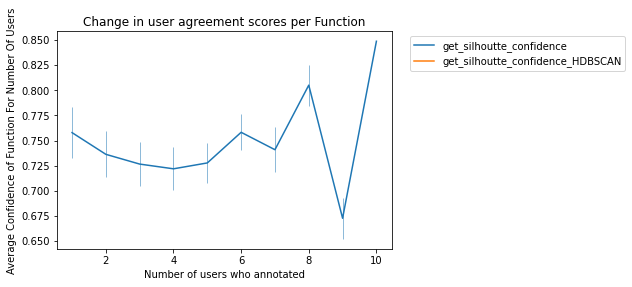

In [45]:
from confidence_functions.confidence import *
%reload_ext autoreload
confidence_funcs =  [get_silhoutte_confidence, get_silhoutte_confidence_HDBSCAN]
experiment_results = experiment_3(data, confidence_funcs, num_of_trials=1000, json_name="experiment_results_old.json")
processed = process_results(experiment_results)
generate_graph_all(processed)

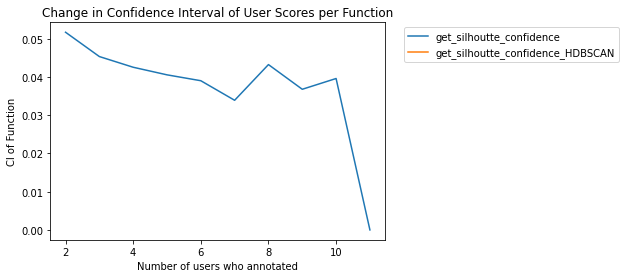

In [44]:
plot_change_in_ci(processed)

# Get JSON Copy of Last Experiment Ran

In [6]:
with open('./experiment_results.json', 'r') as fcc_file:
    experiment_results = json.load(fcc_file)
    print(experiment_results)

{'get_silhoutte_confidence': {'0': [], '1': [0.3563649052250318, 0.5903774597683469, 0.9746665925662353, 0.9311813921270669, 0.4104300129903845, 0.3978433186406213, 0.0, 0.30407130730889853, 0.3725080669987158, 0.2996703984127571, 0.32990276993598194, 0.5591496265843614, 0.9819875594708971, 0.29496024448026364, 0.47869213237663033, 0.0, 0.3988274630644245, 0.37440609493484295, 0.4924242356622268, 0.48660279020548974, 0.4807692246637642, 0.0, 0.3682646246980215, 0.3762228750428031, 0.2841154524879408, 0.0, 0.0, 0.5221085583902391, 0.990095405107789, 0.36231416980459796, 0.7284884508730045, 0.4650160536251593, 0.0, 0.3445199995028739, 0.9393458884186858, 0.3445199995028739, 0.37854815862775737, 0.3553246006870319, 0.0, 0.31688667297451656, 0.5628169258859382, 0.7921920139499294, 0.47869213237663033, 0.7676342432028034, 0.47751807736475355, 0.2506191785008715, 0.8925375029739722, 0.2734903803485126, 0.9499999965003028, 0.0, 0.0, 0.0, 0.4911677594052356, 0.4966356337108552, 0.2137880883200